In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def transform_df(df_transformers, save_in_excel=False):
    # = pd.read_csv('../NERs/results_pretrained_models.csv')

    pivoted_df = (df_transformers
              .set_index(['model', 'prediction_level', 'dataset', 'split'])
              [['F1', 'Precision', 'Recall']]
              .unstack(['dataset', 'split'])
              .reorder_levels(['dataset', 'split', None], axis=1)
              .sort_index(axis=1))

    sorted_df = pivoted_df.sort_values(
    by=[('docred', 'dev', 'F1')],  # Target column (as tuple)
    ascending=False
    )
    sorted_df = sorted_df.round(5) * 100
    sorted_df.reset_index(inplace=True)

    sorted_df['model'] = sorted_df['model'].str.replace('flair', 'flair/ner-english-ontonotes-fast-v0.14.0')
    #sorted_df['model'] = sorted_df['model'].str.replace('gliner', 'urchade/gliner_large-v2.1')
    sorted_df['model'] = sorted_df['model'].str.replace('xlm-roberta-large-finetuned-conll03-english', 'FacebookAI/xlm-roberta-large-finetuned-conll03-english')
    sorted_df['model'] = sorted_df['model'].apply(lambda x: 'spaCy/' + x + '-v3.8.0' if 'en_core_' in x else x)
    sorted_df['model'] = sorted_df['model'].str.replace('wikineural-multilingual-ner-fine-tuned', 'Babelscape/wikineural-multilingual-ner*')

    if save_in_excel:
        sorted_df.to_excel('NER_results.xlsx', sheet_name='pretrained_models')

    return sorted_df

In [11]:
# def ner_lollipop(df_transformers):
#     df_subset = df_transformers.loc[:, [('model', '', ''), ('prediction_level', '', ''), ('redocred', 'test', 'F1')]]
#     df_subset.columns = ['_'.join(col).strip('_') for col in df_subset.columns.values]
#     df_subset = df_subset.pivot(index='model', columns='prediction_level', values='redocred_test_F1').reset_index()
#
#     # sort and then reset to get a fresh 0..N-1 index
#     df_sorted = df_subset.sort_values(by='sentence').reset_index(drop=True)
#
#     fig, ax = plt.subplots(figsize=(10, 8))
#
#     for y, row in df_sorted.iterrows():
#         x_doc = row['document']
#         x_sent = row['sentence']
#         # horizontal line
#         ax.plot([x_doc, x_sent], [y, y], color='gray', linewidth=1)
#         # dots
#         ax.scatter(x_doc, y, color='tab:blue', s=80, label='Document' if y == 0 else "")
#         ax.scatter(x_sent, y, color='tab:orange', marker='D', s=80, label='Sentence' if y == 0 else "")
#
#     # now y is 0..len(df)-1, so labels line up
#     ax.set_yticks(df_sorted.index)
#     ax.set_yticklabels(df_sorted['model'])
#     ax.set_xlabel('Re-DocRED Test F1 Score')
#     #ax.set_title('Lollipop Chart: Re-DocRED Test F1 by Prediction Level')
#     ax.legend()
#     ax.grid(axis='x', linestyle='--', alpha=0.5)
#     plt.tight_layout()
#
#     plt.savefig('transformers_doc_vs_sent.pdf', format="pdf")
#     plt.show()
def ner_lollipop(df_transformers):
    # 1) Extract and pivot
    df_subset = df_transformers.loc[:, [
        ('model', '', ''),
        ('prediction_level', '', ''),
        ('redocred', 'test', 'F1')
    ]]
    df_subset.columns = ['_'.join(col).strip('_') for col in df_subset.columns.values]
    df_subset = df_subset.pivot(
        index='model',
        columns='prediction_level',
        values='redocred_test_F1'
    ).reset_index()

    df_sorted = df_subset.sort_values(by='sentence').reset_index(drop=True)

    # 2) Dynamic figure height: ~0.25in per model, min 4in
    n = len(df_sorted)
    height = max(4, n * 0.25)
    fig, ax = plt.subplots(figsize=(10, height))

    # 3) Plot lollipops
    for y, row in df_sorted.iterrows():
        x_doc, x_sent = row['document'], row['sentence']
        ax.plot([x_doc, x_sent], [y, y], color='gray', linewidth=1)
        ax.scatter(x_doc, y, color='tab:blue', s=60,
                   label='Document' if y == 0 else "")
        ax.scatter(x_sent, y, color='tab:orange', marker='D', s=60,
                   label='Sentence' if y == 0 else "")

    # 4) Ticks, labels, and tight layout
    ax.set_yticks(range(n))
    ax.set_yticklabels(df_sorted['model'], fontsize=8)
    ax.set_ylim(-0.5, n - 0.5)  # remove extra padding at top/bottom
    ax.set_xlabel('Re-DocRED Test F1 Score')
    ax.legend(ncol=2, frameon=False)
    ax.grid(axis='x', linestyle='--', alpha=0.5)

    # tighten margins to squeeze ticks in
    plt.tight_layout(pad=0.5)
    plt.savefig('transformers_doc_vs_sent2.pdf', format="pdf")
    plt.show()

In [12]:
def ner_grouped_barplot(df_transformers):
    df = df_transformers[df_transformers.prediction_level == 'sentence']

    f1_cols = [
        ('docred',   'dev',  'F1'),
        ('docred',   'test', 'F1'),
        ('redocred', 'dev',  'F1'),
        ('redocred', 'test', 'F1'),
    ]

    # 2) Extract model names and data, then reverse both
    models = df[('model','','')].tolist()[::-1]
    data = np.vstack([df[col].values for col in f1_cols]).T[::-1]

    # 3) Plot setup
    n = len(models)
    x = np.arange(n)
    width = 0.2

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    hatches =    ['/',         '\\\\\\',        'xx',         '.']
    labels =     ['DocRED Dev','DocRED Test','Re-DocRED Dev','Re-DocRED Test']

    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(4):
        ax.bar(
            x + (i-1.5)*width,      # offsets: -1.5, -0.5, +0.5, +1.5
            data[:, i],
            width,
            color=colors[i],
            hatch=hatches[i],
            edgecolor='black',
            label=labels[i]
        )

    # 4) Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=90, fontsize=10)
    ax.set_ylabel('F1 Score')
    #ax.set_title('F1 by Model, Dataset & Split')
    ax.legend(ncol=2, frameon=False)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_ylim((60, None))

    plt.tight_layout()

    plt.savefig('transformers_sent_across_splits.pdf', format="pdf")
    plt.show()

In [13]:
df_transformers = pd.read_csv('../NERs/results_pretrained_models.csv')
df_transformers = transform_df(df_transformers)
df_transformers

dataset                                              model prediction_level  \
split                                                                         
                                                                              
0                  Babelscape/wikineural-multilingual-ner*         sentence   
1                  Babelscape/wikineural-multilingual-ner*         document   
2        FacebookAI/xlm-roberta-large-finetuned-conll03...         sentence   
3                   Babelscape/wikineural-multilingual-ner         sentence   
4                                     dslim/bert-large-NER         sentence   
5                   Babelscape/wikineural-multilingual-ner         document   
6                                      dslim/bert-base-NER         sentence   
7        FacebookAI/xlm-roberta-large-finetuned-conll03...         document   
8                                     dslim/bert-large-NER         document   
9                                      dslim/bert-base-NER         document   
10                            spaCy/en_core_web_trf-v3.8.0         sentence   
11                            spaCy/en_core_web_trf-v3.8.0         document   
12                             spaCy/en_core_web_lg-v3.8.0         sentence   
13                             spaCy/en_core_web_lg-v3.8.0         document   
14                             dslim/bert-base-NER-uncased         sentence   
15                             spaCy/en_core_web_sm-v3.8.0         sentence   
16                             spaCy/en_core_web_sm-v3.8.0         document   
17                             dslim/bert-base-NER-uncased         document   
18                flair/ner-english-ontonotes-fast-v0.14.0         sentence   
19                               urchade/gliner_large-v2.1         sentence   
20                flair/ner-english-ontonotes-fast-v0.14.0         document   

dataset  docred                                             redocred  \
split       dev                      test                        dev   
             F1 Precision  Recall      F1 Precision  Recall       F1   
0        92.258    92.850  91.673  92.837    93.148  92.528   92.190   
1        89.667    90.027  89.311  90.252    90.310  90.194   88.984   
2        79.643    89.908  71.482  79.983    90.177  71.860   79.739   
3        79.373    90.561  70.644  79.498    90.901  70.638   79.378   
4        78.591    88.685  70.560  78.612    88.580  70.661   78.617   
5        78.315    89.310  69.730  78.277    89.255  69.703   77.565   
6        77.523    86.894  69.976  77.578    86.777  70.142   77.788   
7        77.147    86.973  69.316  77.667    87.524  69.806   76.495   
8        76.508    86.195  68.778  76.934    86.751  69.113   76.105   
9        75.111    84.304  67.725  75.237    84.389  67.876   74.788   
10       74.619    74.633  74.604  75.028    75.041  75.015   74.764   
11       73.445    73.651  73.241  73.218    73.442  72.995   73.470   
12       73.219    73.459  72.980  73.572    73.917  73.229   73.171   
13       73.001    73.332  72.672  73.399    73.823  72.980   72.926   
14       72.811    82.882  64.922  73.011    83.039  65.145   72.921   
15       71.995    72.920  71.094  72.014    73.193  70.872   71.821   
16       71.822    72.750  70.917  71.860    73.037  70.721   71.592   
17       70.985    80.755  63.324  70.826    80.350  63.321   70.585   
18       66.331    66.211  66.450  66.662    66.462  66.862   65.660   
19       65.564    64.220  66.965  65.942    65.315  66.582   65.320   
20       44.983    44.788  45.180  45.799    45.599  46.001   44.598   

dataset                                              
split                        test                    
        Precision  Recall      F1 Precision  Recall  
0          92.758  91.629  92.351    92.958  91.752  
1          89.290  88.679  90.393    90.798  89.992  
2          90.033  71.558  79.559    89.819  71.403  
3          90.623  70.615  79.367    90.505  70.67

In [14]:
df_transformers.model = df_transformers.model.str.split('/').apply(lambda x: x[1])

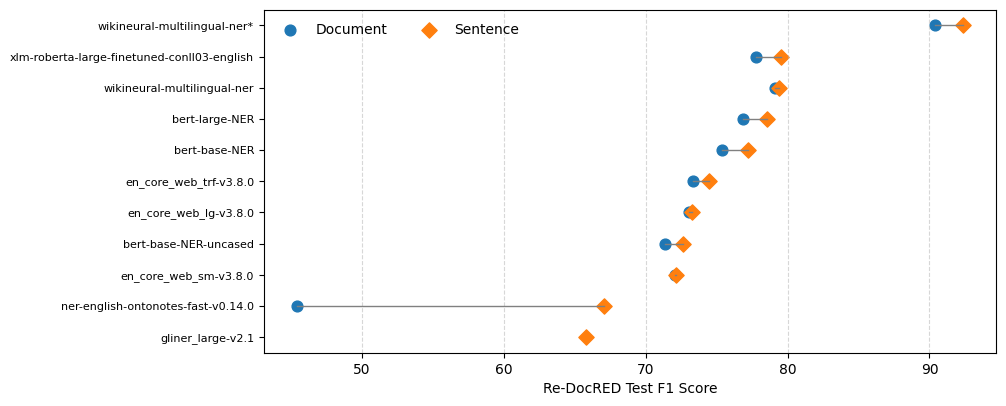

In [15]:
ner_lollipop(df_transformers)

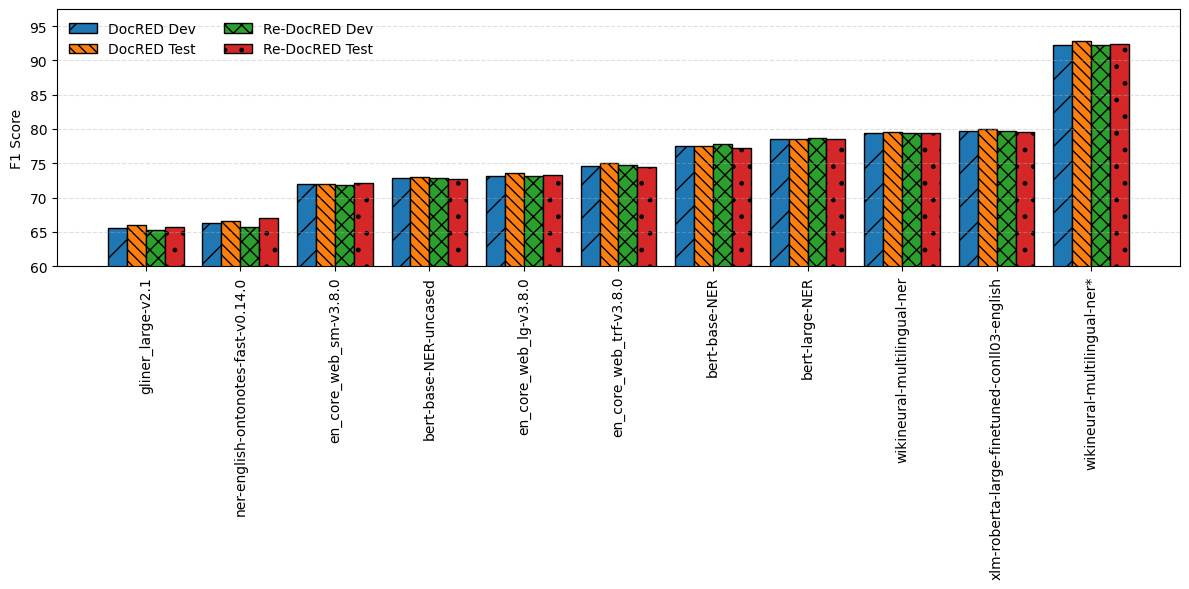

In [16]:
ner_grouped_barplot(df_transformers)

In [20]:
df_transformers.model.unique().tolist()

['wikineural-multilingual-ner*',
 'xlm-roberta-large-finetuned-conll03-english',
 'wikineural-multilingual-ner',
 'bert-large-NER',
 'bert-base-NER',
 'en_core_web_trf-v3.8.0',
 'en_core_web_lg-v3.8.0',
 'bert-base-NER-uncased',
 'en_core_web_sm-v3.8.0',
 'ner-english-ontonotes-fast-v0.14.0',
 'gliner_large-v2.1']